In [ ]:
!pip install pylatexenc qiskit[machine-learning]

     |████████████████████████████████| 162 kB 4.6 MB/s 
     |████████████████████████████████| 6.1 MB 18.8 MB/s 
     |████████████████████████████████| 17.9 MB 1.3 MB/s 
     |████████████████████████████████| 237 kB 57.7 MB/s 
     |████████████████████████████████| 207 kB 58.3 MB/s 
     |████████████████████████████████| 2.1 MB 51.1 MB/s 
     |████████████████████████████████| 96 kB 5.5 MB/s 
     |████████████████████████████████| 634 kB 68.4 MB/s 
     |████████████████████████████████| 1.4 MB 41.6 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 943 kB 61.3 MB/s 
     |████████████████████████████████| 38.2 MB 22 kB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 3.5 MB 29.5 MB/s 
     |████████████████████████████████| 6.3 MB 38.4 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136833 sha256=acf28190566cfe29fb12a0c656581fedc07108e8af3ae

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterVector
from qiskit.circuit.parametertable import ParameterView
from qiskit.circuit.library import PauliFeatureMap, EfficientSU2
from qiskit.algorithms.optimizers import COBYLA

from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

import gensim
import torch
import torch.nn as nn
import pickle
from sklearn.decomposition import PCA

import itertools

from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocess Word Embeddings

In [ ]:
with open(r"/content/drive/MyDrive/pre_ft_vectors", "rb") as input_file:
  embeddings_dict = pickle.load(input_file)

# Preprocess Data

In [ ]:
with open("/content/drive/MyDrive/amazon_reviews_data.txt") as f:
  raw_corpus = f.readlines()

In [ ]:
corpus = [ { "sentence": [''.join(e for e in word if e.isalnum()).lower() for word in sentence.split()[:-1]], "sentiment": int(sentence.split()[-1]) }  for sentence in raw_data ]
corpus

[{'sentence': ['so',
   'there',
   'is',
   'no',
   'way',
   'for',
   'me',
   'to',
   'plug',
   'it',
   'in',
   'here',
   'in',
   'the',
   'us',
   'unless',
   'i',
   'go',
   'by',
   'a',
   'converter'],
  'sentiment': 0},
 {'sentence': ['good', 'case', 'excellent', 'value'], 'sentiment': 1},
 {'sentence': ['great', 'for', 'the', 'jawbone'], 'sentiment': 1},
 {'sentence': ['tied',
   'to',
   'charger',
   'for',
   'conversations',
   'lasting',
   'more',
   'than',
   '45',
   'minutesmajor',
   'problems'],
  'sentiment': 0},
 {'sentence': ['the', 'mic', 'is', 'great'], 'sentiment': 1},
 {'sentence': ['i',
   'have',
   'to',
   'jiggle',
   'the',
   'plug',
   'to',
   'get',
   'it',
   'to',
   'line',
   'up',
   'right',
   'to',
   'get',
   'decent',
   'volume'],
  'sentiment': 0},
 {'sentence': ['if',
   'you',
   'have',
   'several',
   'dozen',
   'or',
   'several',
   'hundred',
   'contacts',
   'then',
   'imagine',
   'the',
   'fun',
   'of',
   

# qTransformer Model

In [81]:
class QuantumTransformer:
    def embed_sentence(self, sentence):
        embedded_sentence = np.array(
            [self.embeddings[word] for word in sentence]
        ).flatten()
        return np.pad(
            embedded_sentence, (0, self.sequence_length - embedded_sentence.size)
        )

    def __init__(
        self,
        sequence_length,
        embedding_dimension,
        embedding_dict,
        quantum_instance=Aer.get_backend("qasm_simulator"),
        reps=1,
        iterations=200,
        include_attention=True,
        include_residual=True,
    ):

        # Model Layers
        def attention_pair(i, j, l=0):
            qc = QuantumCircuit(2)
            qc.u(*ParameterVector("atn_%d_pair_%d%d_0" % (l, i, j), length=3), 0)
            qc.u(*ParameterVector("atn_%d_pair_%d%d_1" % (l, i, j), length=3), 1)
            qc.cx(1, 0)
            qc.u(*ParameterVector("atn_%d_pair_%d%d_2" % (l, i, j), length=3), 0)
            qc.u(*ParameterVector("atn_%d_pair_%d%d_3" % (l, i, j), length=3), 1)
            qc.cx(0, 1)
            qc.u(*ParameterVector("atn_%d_pair_%d%d_4" % (l, i, j), length=3), 0)
            qc.u(*ParameterVector("atn_%d_pair_%d%d_5" % (l, i, j), length=3), 1)
            qc.cx(1, 0)
            qc.u(*ParameterVector("atn_%d_pair_%d%d_6" % (l, i, j), length=3), 0)
            qc.u(*ParameterVector("atn_%d_pair_%d%d_7" % (l, i, j), length=3), 1)
            return qc.to_gate(label="Attention(%d, %d)" % (i, j))

        def attention(n, l=0):
            qc = QuantumCircuit(n)
            for pair in itertools.combinations(range(n), 2):
                qc.append(attention_pair(*pair, l=l), pair)
            return qc.to_gate(label="Attention")

        def residual(n):
            qc = QuantumCircuit(2 * n)
            for i in range(n):
                qc.cx(n + i, i)
            return qc.to_gate(label="Residual")

        # Classifier Utilities
        def parity(x):
            return "{:b}".format(x).count("1") % 2

        def callback_graph(weights, obj_func_eval):
            clear_output(wait=True)
            objective_func_vals.append(obj_func_eval)
            plt.title("Objective Function vs. Iteration")
            plt.xlabel("Iteration")
            plt.ylabel("Objective Function")
            plt.plot(range(len(objective_func_vals)), objective_func_vals)
            plt.show()

        self.sequence_length = sequence_length
        self.embedding_dimension = embedding_dimension

        n = self.sequence_length * self.embedding_dimension

        pca = PCA(n_components=self.embedding_dimension)
        self.embeddings = {}
        word_to_num = {}
        embeds_matrix = []

        for i, word in enumerate(embedding_dict.vocab.keys()):
            word_to_num[word] = i
            embeds_matrix.append(embedding_dict[word])

        embeds_matrix = np.array(embeds_matrix)
        embeds_matrix = pca.fit_transform(embeds_matrix)
        for word in embedding_dict.vocab.keys():
            self.embeddings[word] = embeds_matrix[word_to_num[word]]

        feature_map = PauliFeatureMap(n)
        if include_attention:
            attention_layers = [attention(n, l=i) for i in range(reps)]
        if include_residual:
            residual_layers = [residual(n) for _ in range(reps)]
        feed_forward_layers = [
            EfficientSU2(n, parameter_prefix=str(i)) for i in range(reps)
        ]

        self.circuit = QuantumCircuit(2 * n if include_residual else n)

        self.circuit.append(feature_map, range(n))
        if include_residual:
            self.circuit.append(feature_map, range(n, 2 * n))

        for i in range(reps):
            if include_attention:
                self.circuit.append(attention_layers[i], range(n))
            if include_residual:
                self.circuit.append(residual_layers[i], range(2 * n))
            self.circuit.append(feed_forward_layers[i], range(n))

        self.network = CircuitQNN(
            circuit=self.circuit,
            input_params=feature_map.parameters,
            weight_params=ParameterView(
                (
                    [parameter for l in attention_layers for parameter in l.params]
                    if include_attention
                    else []
                )
                + [parameter for l in feed_forward_layers for parameter in l.parameters]
            ),
            interpret=parity,
            output_shape=2,
            quantum_instance=quantum_instance,
        )

        self.classifier = NeuralNetworkClassifier(
            neural_network=self.network,
            optimizer=COBYLA(maxiter=iterations),
            callback=callback_graph,
        )

    def preprocess_data(self, corpus):
        filtered_sequences = []
        for sentence in corpus:
            sequences = [
                {
                    "sentence": sentence["sentence"][i : i + self.sequence_length],
                    "sentiment": sentence["sentiment"],
                }
                for i in range(0, len(sentence["sentence"]), self.sequence_length)
            ]
            for sequence in sequences:
                if all(word in self.embeddings for word in sequence["sentence"]):
                    filtered_sequences.append(sequence)
        filtered_sequences = [
            sentence for sentence in filtered_sequences if len(sentence["sentence"]) > 2
        ]

        vocab = []
        for sequence in filtered_sequences:
            vocab.extend(sequence["sentence"])
        vocab = list(set(vocab))

        X = np.array(
            [
                self.embed_sentence(sentence["sentence"])
                for sentence in filtered_sequences
            ]
        )
        Y = np.array(
            [
                sentence["sentiment"]
                for sentence in filtered_sequences
                if len(sentence["sentence"]) > 2
            ]
        )

        return X, Y

    def train(self, X, Y):
        plt.rcParams["figure.figsize"] = (12, 6)
        self.classifier.fit(X, Y)
        plt.rcParams["figure.figsize"] = (6, 4)

    def score(self, X, Y):
        return self.classifier.score(X, Y)

    def predict(self, sentence):
        print()
        return self.classifier.predict(
            self.embed_sentence(
                [
                    "".join(e for e in word if e.isalnum()).lower()
                    for word in sentence.split()
                ]
            )
        )


# Performance Evaluation

In [82]:
EMBEDDING_DIMS = 1
TRAIN_DATA_SIZE = 50
SEQUENCE_LENGTH = 4

## w/o Attention

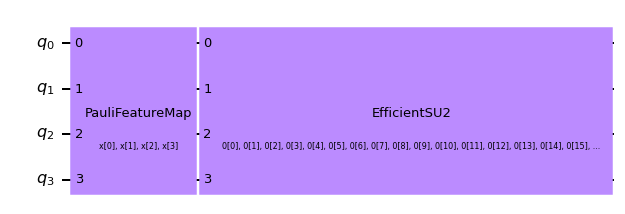

In [83]:
transformer = QuantumTransformer(sequence_length=SEQUENCE_LENGTH, embedding_dimension=EMBEDDING_DIMS, embedding_dict=embeddings_dict, include_attention=0, include_residual=0)
transformer.circuit.draw("mpl") 

In [84]:
X, Y = transformer.preprocess_data(corpus)

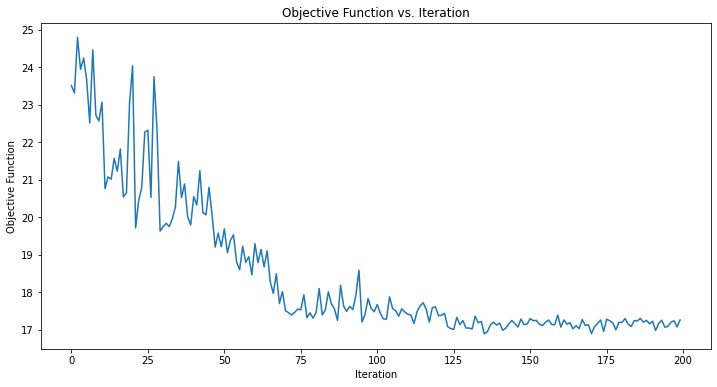

In [85]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
transformer.classifier.fit(X[:TRAIN_DATA_SIZE], Y[:TRAIN_DATA_SIZE])
plt.rcParams["figure.figsize"] = (6, 4)

In [86]:
transformer.classifier.score(X[:TRAIN_DATA_SIZE], Y[:TRAIN_DATA_SIZE])

0.78

In [87]:
transformer.classifier.score(X[TRAIN_DATA_SIZE:2*TRAIN_DATA_SIZE], Y[TRAIN_DATA_SIZE:2*TRAIN_DATA_SIZE])

0.52

## w/ Attention w/o Residual

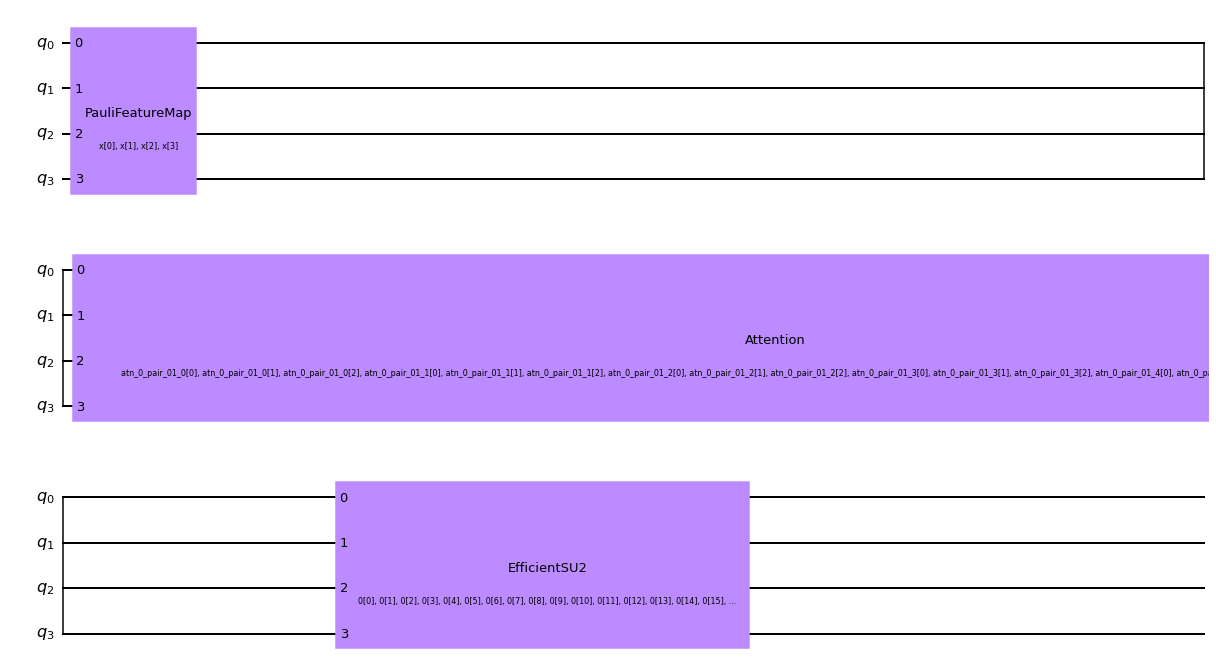

In [88]:
transformer = QuantumTransformer(sequence_length=SEQUENCE_LENGTH, embedding_dimension=EMBEDDING_DIMS, embedding_dict=embeddings_dict, reps=1, include_attention=1, include_residual=0)
transformer.circuit.draw("mpl") 

In [89]:
X, Y = transformer.preprocess_data(corpus)

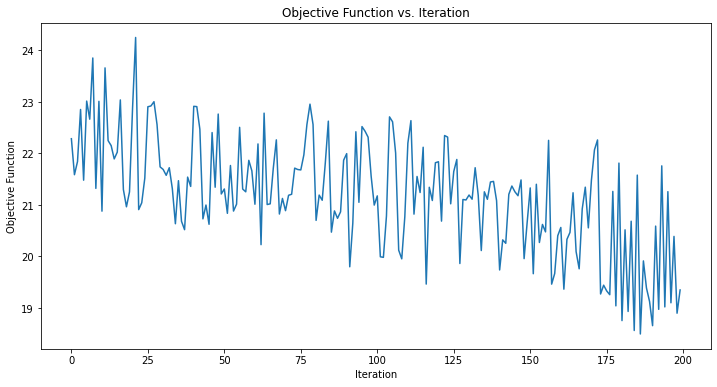

In [90]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
transformer.classifier.fit(X[:TRAIN_DATA_SIZE], Y[:TRAIN_DATA_SIZE])
plt.rcParams["figure.figsize"] = (6, 4)

In [91]:
transformer.classifier.score(X[:TRAIN_DATA_SIZE], Y[:TRAIN_DATA_SIZE])

0.8

In [92]:
transformer.classifier.score(X[TRAIN_DATA_SIZE:2*TRAIN_DATA_SIZE], Y[TRAIN_DATA_SIZE:2*TRAIN_DATA_SIZE])

0.46

## w/Attention w/Residual

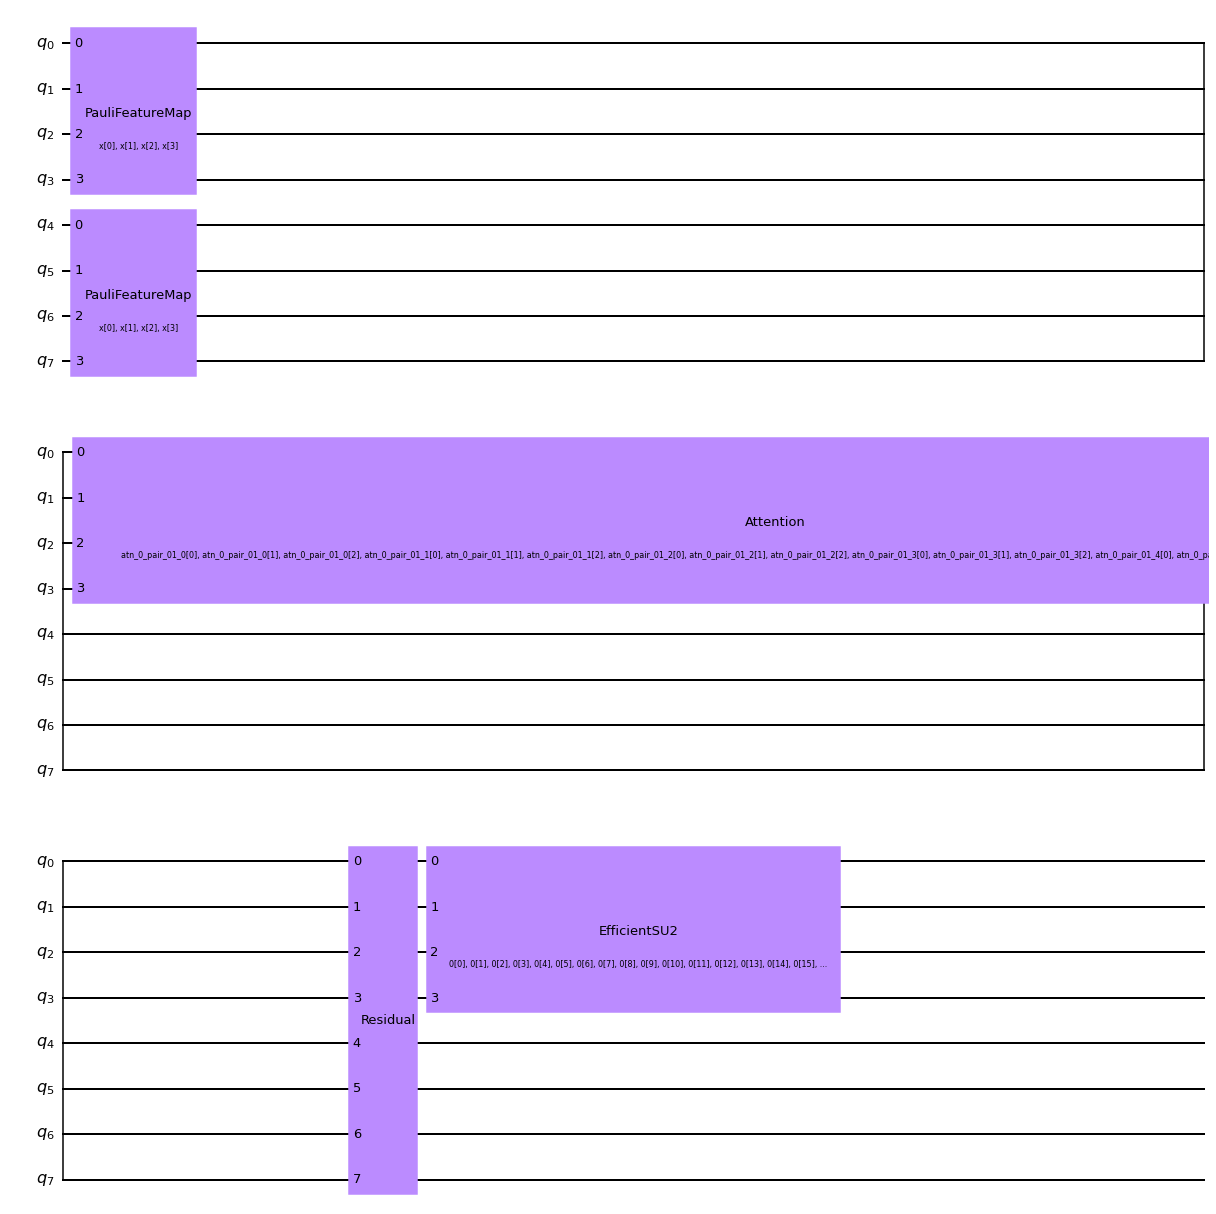

In [93]:
transformer = QuantumTransformer(sequence_length=SEQUENCE_LENGTH, embedding_dimension=EMBEDDING_DIMS, embedding_dict=embeddings_dict, reps=1, include_attention=1, include_residual=1)
transformer.circuit.draw("mpl") 

In [ ]:
X, Y = transformer.preprocess_data(corpus)

In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
transformer.classifier.fit(X[:TRAIN_DATA_SIZE], Y[:TRAIN_DATA_SIZE])
plt.rcParams["figure.figsize"] = (6, 4)

In [ ]:
transformer.classifier.score(X[:TRAIN_DATA_SIZE], Y[:TRAIN_DATA_SIZE])

In [ ]:
transformer.classifier.score(X[TRAIN_DATA_SIZE:2*TRAIN_DATA_SIZE], Y[TRAIN_DATA_SIZE:2*TRAIN_DATA_SIZE])

# 2x qTransformer Blocks w/ Attention 

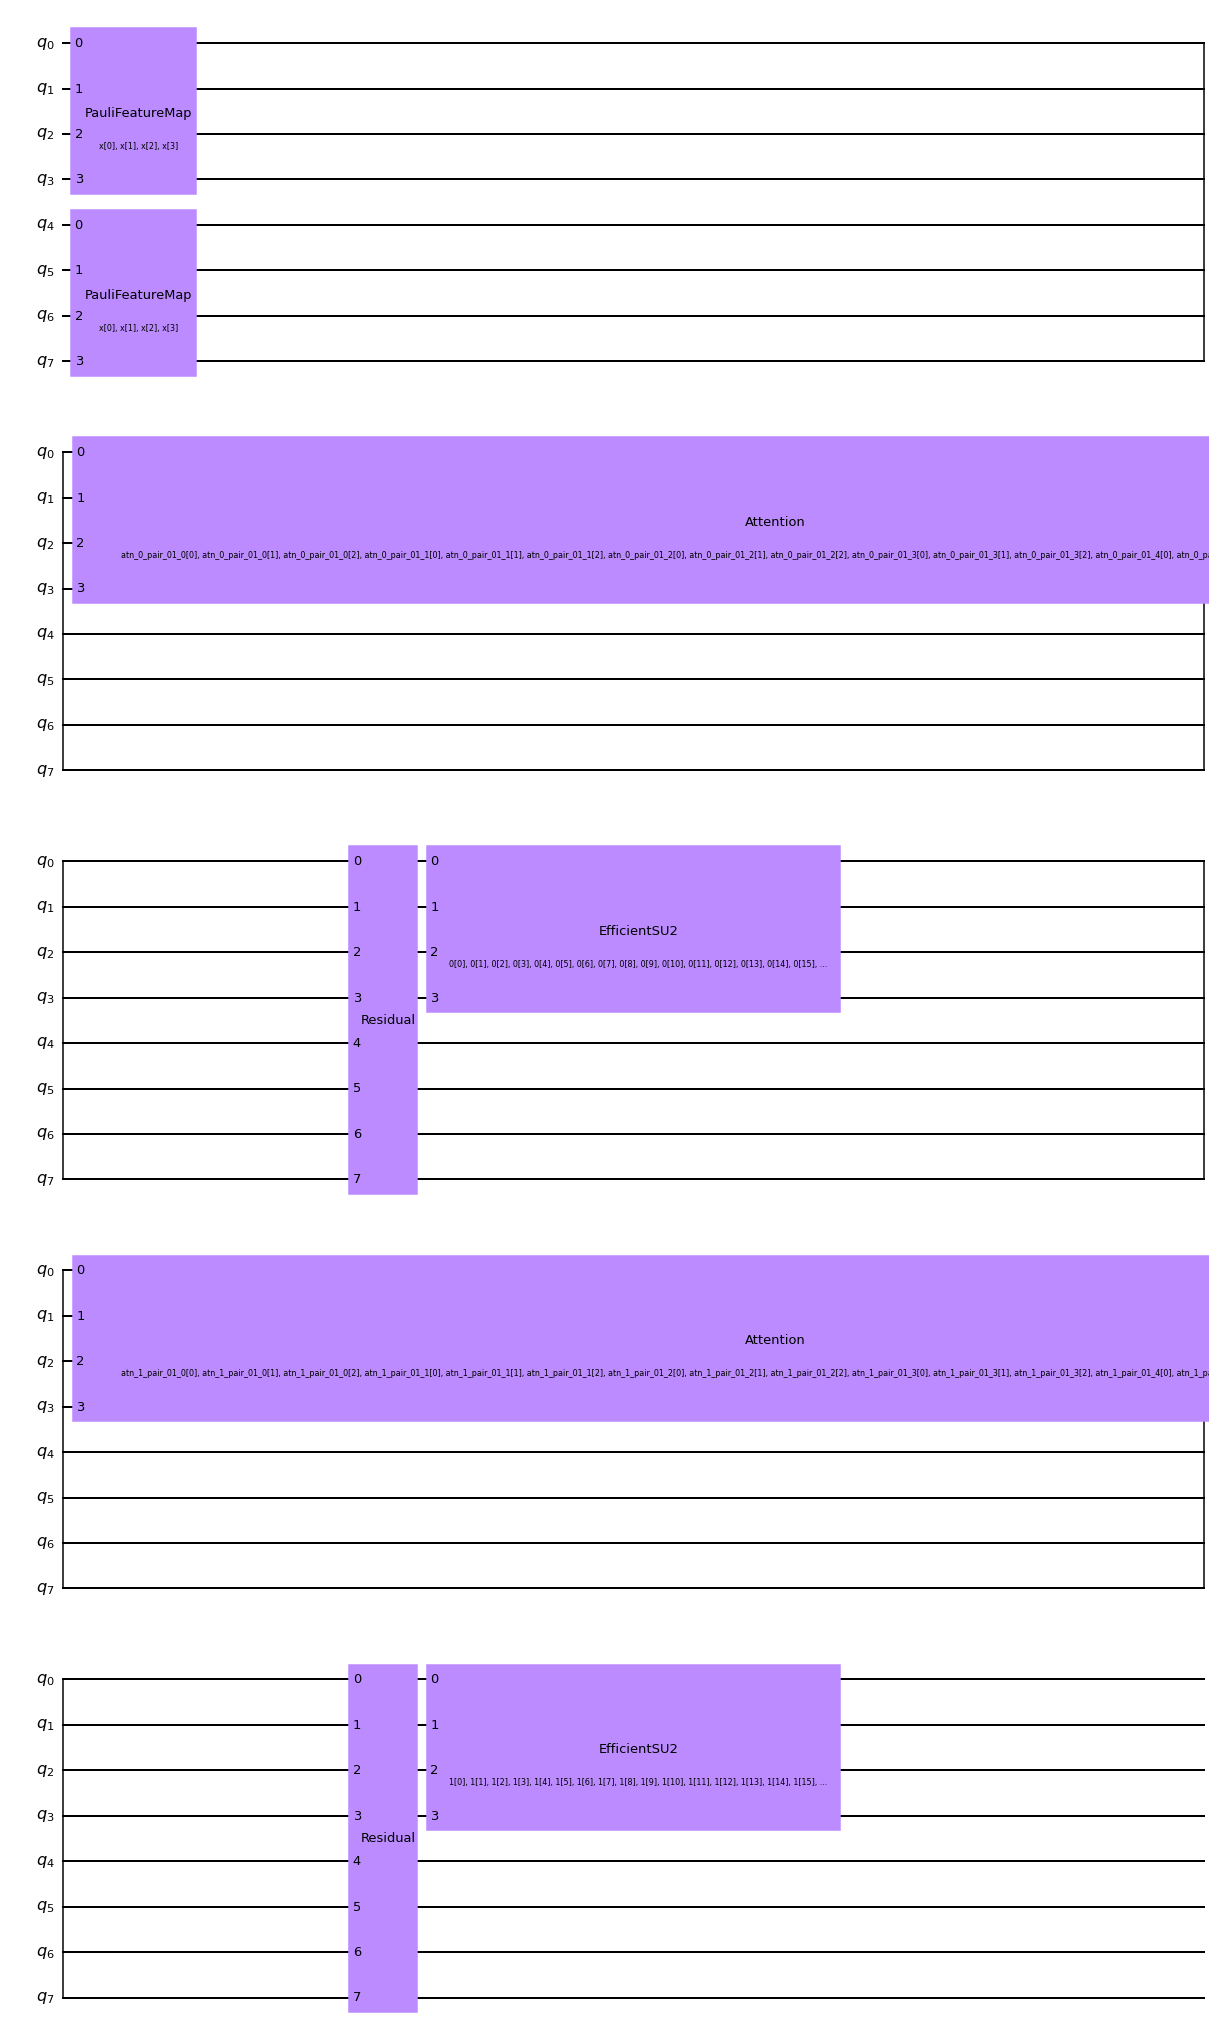

In [94]:
transformer = QuantumTransformer(sequence_length=SEQUENCE_LENGTH, embedding_dimension=EMBEDDING_DIMS, embedding_dict=embeddings_dict, reps=2, include_attention=1, include_residual=1)
transformer.circuit.draw("mpl") 

In [ ]:
X, Y = transformer.preprocess_data(corpus)

In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
transformer.classifier.fit(X[:TRAIN_DATA_SIZE], Y[:TRAIN_DATA_SIZE])
plt.rcParams["figure.figsize"] = (6, 4)

In [ ]:
transformer.classifier.score(X[:TRAIN_DATA_SIZE], Y[:TRAIN_DATA_SIZE])

In [ ]:
transformer.classifier.score(X[TRAIN_DATA_SIZE:2*TRAIN_DATA_SIZE], Y[TRAIN_DATA_SIZE:2*TRAIN_DATA_SIZE])